In [1]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely

from general_functions import *
pd.set_option('display.max_columns', None)


# Wetterskip Fryslan

In [2]:
gpkg_path_Wetterskip = "..\..\Data_preprocessed\Waterschappen\Wetterskip\Wetterskip_gecorrigeerde_geometrie.gpkg"
output_gpkg_path_Wetterskip = "../../Data_postprocessed/Waterschappen/Wetterskip/Wetterskip"

peilgebiedpraktijk_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\Nieuwe_peilgebieden\MIPWA_20230907WF.gpkg"
streefpeil_path = r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\Wetterskip\Nieuwe_peilgebieden\MIPWA_20230907WF.gpkg"

In [3]:
# Duikersifonhevel and hydroobject have a type of multicurvedZ, the peilgebieden a MultiSurfaceZ, which geopandas can not handle. I have manually 
# exported these to single shapes, which automatically converts it to regular MultiStrings. Then these layers have been packed together to a
# geopackage again. 

#retrieve the data
Wetterskip = read_gpkg_layers(gpkg_path = gpkg_path_Wetterskip, 
                        variables = ['stuw', 
                                     'gemaal', 
                                     'afsluitmiddel',
                                     'hydroobject',
                                     'duikersifonhevel'],
                                     # 'peilmerk',
                                     # 'streefpeil',
                                     # 'peilgebiedpraktijk', 
                                     # 'peilgebiedvigerend',
                                     # 'peilbesluitgebied'],
                        print_var = False)

#The peilgebieden en streefpeilen have been delivered as additional data
peilgebiedpraktijk = gpd.read_file(peilgebiedpraktijk_path,
                                   layer = 'DAMO_W_PeilgebiedPraktijk')

streefpeil = gpd.read_file(streefpeil_path,
                           layer = 'DAMO_W_Streefpeil')


<AxesSubplot:>

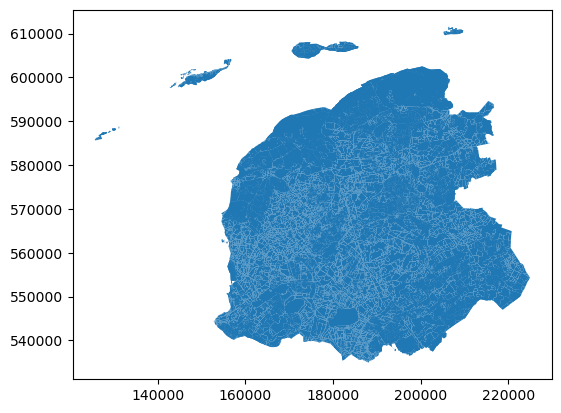

In [4]:
#merge the streefpeil and the peilgebieden
peilgebied = pd.merge(left = streefpeil,
                  right = peilgebiedpraktijk,
                  left_on = 'PEILGEBIEDPRAKTIJKID',
                  right_on = 'GLOBALID')

peilgebied = gpd.GeoDataFrame(peilgebied, geometry = 'geometry_y', crs='EPSG:28992')
peilgebied.reset_index(drop=True, inplace = True)
peilgebied.plot()

In [5]:
peilgebied = peilgebied.explode(ignore_index = True, index_parts=False)
# peilgebied

In [6]:
Wetterskip['peilgebied'] = peilgebied[['WATERHOOGTE', 'nen3610id_y', 'GLOBALID_y', 'geometry_y']]
Wetterskip['peilgebied'] = Wetterskip['peilgebied'].rename(columns = {'WATERHOOGTE':'waterhoogte',
                                                                      'nen3610id_y':'nen3610id',
                                                                      'GLOBALID_y':'globalid',
                                                                      'geometry_y':'geometry'})

#give new globalids and codes, as the peilgebied.explode() results in non unique values.
Wetterskip['peilgebied']['code'] = 'dummy_code_peilgebied_' + Wetterskip['peilgebied'].index.astype(str)
Wetterskip['peilgebied']['globalid'] = 'dummy_globalid_peilgebied_' + Wetterskip['peilgebied'].index.astype(str)

#create the streefpeilen layer
Wetterskip['streefpeil'] = Wetterskip['peilgebied'][['waterhoogte', 'globalid', 'geometry']]
Wetterskip['peilgebied'] = Wetterskip['peilgebied'][['code', 'nen3610id', 'globalid', 'geometry']]

Wetterskip['streefpeil']['geometry'] = None

Wetterskip['streefpeil'] = gpd.GeoDataFrame(Wetterskip['streefpeil'], geometry='geometry', crs='EPSG:28992')
Wetterskip['peilgebied'] = gpd.GeoDataFrame(Wetterskip['peilgebied'], geometry='geometry', crs='EPSG:28992')


In [7]:
Wetterskip['stuw']['geometry'] = Wetterskip['stuw'].centroid #prevent strange geometries
Wetterskip['gemaal']['geometry'] = Wetterskip['gemaal'].centroid #prevent strange geometries

Wetterskip['hydroobject'] = Wetterskip['hydroobject'].loc[Wetterskip['hydroobject'].categorieo == 'primair'] #feedback WS Fryslan: only use primaire hydroobjecten

In [8]:
#determine aanvoer en afvoer gemalen
Wetterskip['gemaal']['func_aanvoer'], Wetterskip['gemaal']['func_afvoer'], Wetterskip['gemaal']['func_circulatie']  = False, False, False #default is False
Wetterskip['gemaal']['functiegemaal'] = Wetterskip['gemaal']['functiegemaal'].astype(str) 

Wetterskip['gemaal'].loc[Wetterskip['gemaal'].functiegemaal.str.contains('Onbekend|Onderbemaling|Afvoergemaal'), 'func_afvoer'] = True
Wetterskip['gemaal'].loc[Wetterskip['gemaal'].functiegemaal.str.contains('Opmaling|Aanvoer'), 'func_aanvoer'] = True
Wetterskip['gemaal'].loc[Wetterskip['gemaal'].functiegemaal.str.contains('Overig|circulatie'), 'func_circulatie'] = True
Wetterskip['gemaal'].loc[(Wetterskip['gemaal'].func_afvoer == False) &
                       (Wetterskip['gemaal'].func_aanvoer == False) &
                       (Wetterskip['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown


In [9]:
#points
Wetterskip['stuw'] = Wetterskip['stuw'][['code', 'globalid', 'nen3610id', 'geometry']]
Wetterskip['gemaal'] = Wetterskip['gemaal'][['code', 'globalid', 'nen3610id', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
Wetterskip['afsluitmiddel'] = Wetterskip['afsluitmiddel'][['code', 'globalid', 'nen3610id', 'geometry']]

#lines
Wetterskip['hydroobject'] = Wetterskip['hydroobject'][['code', 'globalid', 'nen3610id', 'geometry']]
Wetterskip['duikersifonhevel'] = Wetterskip['duikersifonhevel'][['code', 'globalid', 'nen3610id', 'geometry']]


In [10]:
# #delete irrelvant data
# variables = ['peilmerk', 
#              'peilgebiedpraktijk', 
#              'peilgebiedvigerend',
#              'peilbesluitgebied', 
#              'peilgebiedpraktijk']

# for variable in variables:
#     if str(variable) in Wetterskip:
#         del Wetterskip[variable]
        

In [14]:
#add duikersifonhevels to the hydroobjecten    
Wetterskip['hydroobject'] = pd.concat([Wetterskip['hydroobject'], Wetterskip['duikersifonhevel']])
Wetterskip['hydroobject'] = Wetterskip['hydroobject'].drop_duplicates(subset='globalid') #in case it is run multiple times
Wetterskip['hydroobject'] = gpd.GeoDataFrame(Wetterskip['hydroobject']).set_crs('epsg:28992')


In [15]:
show_layers_and_columns(waterschap = Wetterskip)

stuw
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'globalid' 'nen3610id' 'func_afvoer' 'func_aanvoer'
 'func_circulatie' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

afsluitmiddel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'globalid' 'nen3610id' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

peilgebied
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  EPSG:28992



In [16]:
store_data(waterschap = Wetterskip, 
           output_gpkg_path = output_gpkg_path_Wetterskip)


# Oud

In [12]:
# layout_path = r"..\..\Data_postprocessed\QGIS_overzicht\routing_style_format3.gpkg"
# output_layout_path =  r"..\..\Data_postprocessed\QGIS_overzicht\routing_style_format2_saved"
# layout = read_gpkg_layers(gpkg_path = layout_path, 
#                         variables = ['stuw', 
#                                      'gemaal', 
#                                      'afsluitmiddel'])#,
#                                      # 'hydroobject',
#                                      # 'duikersifonhevel',
#                                      # 'streefpeil',
#                                      # 'peilgebiedpraktijk', 
#                                      # 'peilgebiedvigerend'])
# store_data(waterschap = layout, 
#            output_gpkg_path = output_layout_path)


In [13]:
# peilgebieden_met_peil = peilgebieden_met_peil.rename(columns = {'code_left':'code',
#                                                                 'globalid_left':'globalid',
#                                                                 'nen3610id_left':'nen3610id',
#                                                                 'geometry_left':'geometry',
#                                                                 'hoogte':'waterhoogte'})
# peilgebieden_met_peil = peilgebieden_met_peil[['waterhoogte','code', 'globalid', 'nen3610id', 'geometry']].reset_index(drop=True)
# peilgebieden_met_peil = peilgebieden_met_peil.drop_duplicates(subset='globalid')

In [14]:
# #bring the peilgebied in the correct format
# extra_peilgebied = peilgebieden_met_peil[['waterhoogte','code','globalid','nen3610id','geometry']].reset_index(drop=True)

# #bring the streefpeil in the correct format
# extra_peil = peilgebieden_met_peil[['waterhoogte', 'globalid']]
# extra_peil = extra_peil.rename(columns = {'globalid':'peilgebiedpraktijkid'})
# extra_peil['peilgebiedvigerendid'] = None
# extra_peil['geometry'] = None

# #add semi dummy globalid's and nen3610id's
# extra_peil['globalid'], extra_peil['nen3610id'] = np.arange(0, len(extra_peil)), np.arange(0, len(extra_peil))
# extra_peil['globalid'] = 'globalid_wetterskip_streefpeil_' + extra_peil['globalid'].astype(str) 
# extra_peil['nen3610id'] = 'nen3610id_wetterskip_' + extra_peil['nen3610id'].astype(str) 


In [15]:
# #add the (geo)dataframes together
# Wetterskip['peilgebied'] = gpd.GeoDataFrame(pd.concat([peilgebied_PV, extra_peilgebied])).reset_index(drop=True)
# Wetterskip['streefpeil'] = gpd.GeoDataFrame(pd.concat([Wetterskip['streefpeil'], extra_peil])).reset_index(drop=True)

In [16]:
# pd.merge(left=Wetterskip['streefpeil'],
#          right=peilgebied_PV,
#          left_on='peilgebiedid',
#          right_on='globalid')

In [17]:
# Wetterskip['streefpeil']['peilgebiedid'] = None
# Wetterskip['streefpeil']['peilgebiedid'].fillna(Wetterskip['streefpeil']['peilgebiedvigerendid'], inplace = True)
# Wetterskip['streefpeil']['peilgebiedid'].fillna(Wetterskip['streefpeil']['peilgebiedpraktijkid'], inplace = True)

# #move the peilgebiedid id to both the peilgebiedenas well as the streefpeilen
# Wetterskip['peilgebied'] = gpd.GeoDataFrame()
# Wetterskip['peilgebied']['peilgebiedid'] = Wetterskip['streefpeil']['peilgebiedid'] 

# Wetterskip['peilgebied'][['code','globalid','nen3610id']] = Wetterskip['streefpeil'][['code','globalid','nen3610id',]] 


# #the peilgebieden have been merged. Drop the irrelevant columns
# Wetterskip['streefpeil'] = Wetterskip['streefpeil'][['waterhoogte', 'peilgebiedid']]#.drop(columns=['peilgebiedvigerendid', 'peilgebiedpraktijkid'], inplace = True)
# # Wetterskip['peilgebied'] = 